In [4]:
# IMPORTS
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import random
import os

from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
tqdm.pandas()

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
BATCH_SIZE = 64
EMBEDDING_DIM = 50
UNITS = 50
NUM_EPOCHS = 20
max_lines = 180000

In [7]:
def preprocess(sent, exclude, sp_tokens=False):
    sent = sent.lower()
    sent = re.sub("'", '', sent)
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.strip()
    sent = re.sub(" +", " ", sent)
    if sp_tokens:
        sent = '<start> ' + sent + ' <end>'
    
    return sent


In [8]:
from keras.preprocessing.text import Tokenizer

def Tokenize(text):
    tokenizer = Tokenizer(oov_token="<unk>",filters='!"#$%&()*+,-/:;=@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(text)
    return tokenizer

In [9]:
# padding
def pad_sequences(x, max_len):
    padded = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_len, padding='post', truncating='post')
    return padded

In [10]:
def load_data(path):
    with open(path, "r", encoding="utf-8") as f:
        lines = f.read().split("\n")
    return lines

In [11]:
lines = load_data("eng_ger.txt")
lines = lines[:max_lines]

print(lines[:5])

['Hi.\tHallo!', 'Hi.\tGrüß Gott!', 'Run!\tLauf!', 'Wow!\tPotzdonner!', 'Wow!\tDonnerwetter!']


In [12]:
def combine(lines):
    data = []
    exclude = string.punctuation
    for line in lines:
        text = line.split("\t")
        prep_inp = preprocess(text[0], exclude=exclude, sp_tokens=False)
        prep_tar = preprocess(text[1], exclude=exclude, sp_tokens=True)
        data.append([prep_inp, prep_tar])
    
    print(data[:5])
    
    # tokenize
    inp_tokenizer = Tokenize([i[0] for i in data])
    tar_tokenizer = Tokenize([i[1] for i in data])

    # convert text to sequences
    inp_seq = inp_tokenizer.texts_to_sequences([i[0] for i in data])
    tar_seq = tar_tokenizer.texts_to_sequences([i[1] for i in data])

    print(inp_seq[:5])
    print(tar_seq[:5])

    # padding
    inp_seq = pad_sequences(inp_seq, max_len=10)
    tar_seq = pad_sequences(tar_seq, max_len=10)

    print(inp_seq[:5])
    print(tar_seq[:5])

    input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(inp_seq, tar_seq, test_size=0.2)

    train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
    train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

    test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val))
    test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

    return train_dataset, test_dataset, inp_tokenizer, tar_tokenizer
    
    


In [13]:
train_dataset, test_dataset, inp_tokenizer, tar_tokenizer = combine(lines)
input_vocab_size = len(inp_tokenizer.word_index) + 1
target_vocab_size = len(tar_tokenizer.word_index) + 1

[['hi', '<start> hallo <end>'], ['hi', '<start> grüß gott <end>'], ['run', '<start> lauf <end>'], ['wow', '<start> potzdonner <end>'], ['wow', '<start> donnerwetter <end>']]
[[2057], [2057], [459], [3724], [3724]]
[[2, 1598, 3], [2, 4079, 1515, 3], [2, 4510, 3], [2, 10096, 3], [2, 12454, 3]]
[[2057    0    0    0    0    0    0    0    0    0]
 [2057    0    0    0    0    0    0    0    0    0]
 [ 459    0    0    0    0    0    0    0    0    0]
 [3724    0    0    0    0    0    0    0    0    0]
 [3724    0    0    0    0    0    0    0    0    0]]
[[    2  1598     3     0     0     0     0     0     0     0]
 [    2  4079  1515     3     0     0     0     0     0     0]
 [    2  4510     3     0     0     0     0     0     0     0]
 [    2 10096     3     0     0     0     0     0     0     0]
 [    2 12454     3     0     0     0     0     0     0     0]]


In [14]:
print(train_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(64, 10), dtype=tf.int32, name=None), TensorSpec(shape=(64, 10), dtype=tf.int32, name=None))>


In [15]:
def detokenize(token,tokenizer):
    # token = token.numpy()
    res = ""
    for i in token:
        if i!=0:
            if(tokenizer.index_word[i]=="<end>"):
                break
            if(tokenizer.index_word[i]=="<start>"):
                continue
            res += tokenizer.index_word[i] + " "
    return res



In [16]:
# 2 layers => 1 embedding layer and 1 LSTM layer

class Encoder(tf.keras.layers.Layer):
    
    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
    
    def call(self, x):
        # x => (batch_size, max_len)
        x = self.embedding(x) # => (batch_size, s, embed_dim)
        enc_outputs = self.rnn(x)
        return enc_outputs[0], enc_outputs[1:]


In [17]:
class AdditiveAttention(tf.keras.layers.Layer):

    def __init__(self, units):
        super().__init__()
        self.W_q = tf.keras.layers.Dense(units, use_bias=False)
        self.W_k = tf.keras.layers.Dense(units, use_bias=False)
        self.W_v = tf.keras.layers.Dense(1, use_bias=False)
    

    def call(self, query, key, value, mask=None):
        query, key = self.W_q(query), self.W_k(key)
        # query => (batch_size, t, units)
        # key => (batch_size, s, units)

        score = self.W_v(
            tf.math.tanh(
                tf.expand_dims(query, 2) + tf.expand_dims(key, 1)
            )
        )
        score = tf.squeeze(score, -1)
        # score => (batch_size, t, s)
        
        if mask is not None:
            score = tf.where(mask, score, -1e6)
        
        attention_weights = tf.nn.softmax(score, axis=-1)
        # attention_weights => (batch_size, t, s)

        context = tf.matmul(attention_weights, value)
        # context => (batch_size, t, units)

        return context, attention_weights


In [18]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self, embed_dim, units, vocab_size):
        super().__init__()

        # Embedding layer to convert tokens to vectors
        self.embedding = tf.keras.layers.Embedding(
            vocab_size, embed_dim, mask_zero=True)
        
        # RNN layer
        self.rnn = tf.keras.layers.LSTM(
            units, return_sequences=True, return_state=True)
        
        # Attention layer
        self.attention = AdditiveAttention(units)

        # Final layer to output logits, we can use 
        # argmax to know which output token is predicted.
        self.fc = tf.keras.layers.Dense(vocab_size)
    

    def call(self, x, enc_outputs, state, mask=None):
        x = self.embedding(x)
        # x => (batch_size, t, embed_dim)

        dec_outputs = self.rnn(x, initial_state=state)
        output = dec_outputs[0]
        state = dec_outputs[1:]
        # output   => (batch_size, t, units) 
        # state[i] => (batch_size, s, units)

        context_vector, attention_weights = self.attention(
            query=output,
            key=enc_outputs,
            value=enc_outputs,
            mask=mask
        )
        # context_vector => (batch_size, t, units)
        # attention_weights => (batch_size, t, s)

        context_rnn_output = tf.concat(
            [context_vector, output], axis=-1)
        # context_rnn_output => (batch_size, t, 2*units)

        pred = self.fc(context_rnn_output)
        # pred => (batch_size, t, vocab_size)
        
        return pred, state, attention_weights


In [19]:
# Creating instances of encoder and decoder
encoder = Encoder(EMBEDDING_DIM, UNITS, input_vocab_size)
decoder = Decoder(EMBEDDING_DIM, UNITS, target_vocab_size)


In [20]:
def loss_fn(y_true, y_pred):
    # y_true => (batch_size, max_len)
    # y_pred => (batch_size, max_len, vocab_size)

    mask = tf.cast(y_true != 0, tf.float32)

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # masking the padding tokens
    loss = tf.reduce_sum(loss * mask)
    return loss

In [21]:
trainer = tf.keras.optimizers.Adam(learning_rate=0.01)

In [22]:
history = {
    'loss': []
}

In [247]:
for epoch in range(NUM_EPOCHS):
    total_loss = 0.

    with tqdm(total=len(train_dataset)) as pbar:
        for batch, (x, y) in enumerate(train_dataset):
            inp_mask = tf.expand_dims(x != 0, axis=1)
            tgt_mask = tf.cast(y != 0, tf.float32)
            
            with tf.GradientTape() as tape:
                loss = tf.constant(0.0)
                enc_outputs, enc_states = encoder(x)
                dec_states = enc_states

                dec_input = tf.expand_dims(y[:, 0], axis=1)
                for t in range(1, x.shape[1]):
                    dec_outputs, dec_states, tmp_a = decoder(
                        dec_input, enc_outputs, 
                        dec_states, inp_mask)

                    loss += loss_fn(
                        tf.expand_dims(y[:, t], axis=1), dec_outputs)
                    dec_input = tf.expand_dims(y[:, t], axis=1)
                    
                loss = loss/tf.reduce_sum(tgt_mask)
            
            variables = (encoder.trainable_variables + 
            decoder.trainable_variables)
            gradients = tape.gradient(loss, variables)
            trainer.apply_gradients(zip(gradients, variables))
            total_loss += loss.numpy()
            pbar.update(1)
        
    epoch_loss = total_loss/len(train_dataset)
    history['loss'].append(epoch_loss)
    print(f'Epoch: {epoch} | Loss: {epoch_loss}')


100%|██████████| 2250/2250 [10:15<00:00,  3.66it/s]


Epoch: 0 | Loss: 3.0401213541030883


100%|██████████| 2250/2250 [09:56<00:00,  3.77it/s]


Epoch: 1 | Loss: 1.788059564696418


100%|██████████| 2250/2250 [09:57<00:00,  3.77it/s]


Epoch: 2 | Loss: 1.4489450137880113


100%|██████████| 2250/2250 [09:59<00:00,  3.75it/s]


Epoch: 3 | Loss: 1.2759853318267398


100%|██████████| 2250/2250 [09:52<00:00,  3.80it/s]


Epoch: 4 | Loss: 1.1762304315037198


100%|██████████| 2250/2250 [09:50<00:00,  3.81it/s]


Epoch: 5 | Loss: 1.1178003440697988


100%|██████████| 2250/2250 [09:49<00:00,  3.82it/s]


Epoch: 6 | Loss: 1.0739805550045438


100%|██████████| 2250/2250 [09:49<00:00,  3.82it/s]


Epoch: 7 | Loss: 1.045177271074719


100%|██████████| 2250/2250 [09:51<00:00,  3.80it/s]


Epoch: 8 | Loss: 1.0219092377291785


100%|██████████| 2250/2250 [09:52<00:00,  3.80it/s]


Epoch: 9 | Loss: 1.0025466074148814


100%|██████████| 2250/2250 [09:52<00:00,  3.80it/s]


Epoch: 10 | Loss: 0.9876225637065039


100%|██████████| 2250/2250 [09:56<00:00,  3.77it/s]


Epoch: 11 | Loss: 0.9767847358915541


100%|██████████| 2250/2250 [09:54<00:00,  3.78it/s]


Epoch: 12 | Loss: 0.9678186881012387


100%|██████████| 2250/2250 [09:50<00:00,  3.81it/s]


Epoch: 13 | Loss: 0.9580294948418935


100%|██████████| 2250/2250 [09:52<00:00,  3.80it/s]


Epoch: 14 | Loss: 0.9528588523334927


100%|██████████| 2250/2250 [09:54<00:00,  3.78it/s]


Epoch: 15 | Loss: 0.9462892627186246


100%|██████████| 2250/2250 [10:01<00:00,  3.74it/s]


Epoch: 16 | Loss: 0.9444270656903585


100%|██████████| 2250/2250 [09:57<00:00,  3.77it/s]


Epoch: 17 | Loss: 0.9391775285402933


100%|██████████| 2250/2250 [10:00<00:00,  3.75it/s]


Epoch: 18 | Loss: 0.934206871509552


100%|██████████| 2250/2250 [10:00<00:00,  3.75it/s]

Epoch: 19 | Loss: 0.9309811730914646


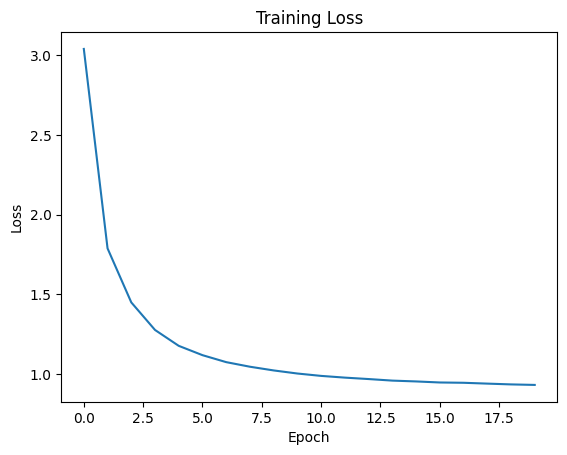

In [248]:
epochs = list(range(len(history['loss'])))
plt.plot(epochs, history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [249]:
tar_tokenizer.word_index['<start>']

2

In [23]:
def predict_seq2seq(encoder, decoder, src_tokens, tar_tokenizer, num_steps):
    enc_X = tf.expand_dims(src_tokens, axis=0)
    mask = tf.expand_dims(enc_X != 0, 1)

    enc_outputs, enc_state = encoder(enc_X, training=False)
    dec_state = enc_state
    dec_X = tf.expand_dims(tf.constant([tar_tokenizer.word_index['<start>']]), axis=0)
    output_seq = []
    attention_weights = []
    for _ in range(num_steps):
        Y, dec_state, att_wgts = decoder(
            dec_X, enc_outputs, dec_state, mask,training=False)
        dec_X = tf.argmax(Y, axis=2)
        pred = tf.squeeze(dec_X, axis=0)
        if pred[0].numpy() == tar_tokenizer.word_index['<end>']:
            break
        output_seq.append(pred[0].numpy())
        attention_weights.append(tf.squeeze(att_wgts, 0))
    attention_weights = tf.squeeze(tf.stack(attention_weights, axis=0), 1)
    return detokenize(output_seq, tar_tokenizer), attention_weights

In [25]:
eng, hin = next(iter(train_dataset))
# print(train_dataset)
# print(eng)

In [26]:
idx = -5
actual_seq = detokenize(hin[idx].numpy(),tar_tokenizer)
translation, att_wgts = predict_seq2seq(encoder, decoder, eng[idx], tar_tokenizer, 10)
eng_sent = detokenize(eng[idx].numpy(), inp_tokenizer)
print(eng_sent)
print(f'English Sentence:      {eng_sent}')
print(f'Predicted Translation: {translation}')
print(f'Actual Translation:    {actual_seq}')

tom participated in the boston marathon 
English Sentence:      tom participated in the boston marathon 
Predicted Translation: city city gehörst gehörst hats beginne harvardpullover harvardpullover dollar hotelreservation 
Actual Translation:    tom nahm am bostonmarathon teil 


In [27]:
def translate(lines,inp_tokenizer,tar_tokenizer,encoder,decoder,max_len=10):
    
    exclude = set(string.punctuation)
    prep_lines = []

    for i in lines:
        prep_lines.append([preprocess(i, exclude, sp_tokens=False)])
    
    input_tensors = []

    for i in prep_lines:
        inp = i[0].split(' ')
        tensor = []
        for j in inp:
            # check for oov
            if j not in inp_tokenizer.word_index.keys():
                tensor.append(inp_tokenizer.word_index['<unk>'])
            else:
                tensor.append(inp_tokenizer.word_index[j])
        input_tensors.append(tensor)
            
    for input_tensor in input_tensors:
        temp_max_len = max(max_len,len(input_tensor))
        for i in range(temp_max_len-len(input_tensor)):
            input_tensor.append(0)

    for input_tensor in input_tensors:
        input_tensor = tf.convert_to_tensor(input_tensor)

    translations = []

    for input_tensor in input_tensors:
        translation, _ = predict_seq2seq(encoder, decoder, input_tensor, tar_tokenizer,10)
        translations.append(translation)
    
    print(translations) 
    
    return translations

In [28]:
print(translate(["anuj","how are you?"],inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder))

['algaddafi weltfriedens nachholen mörder“ sonderbehandlung windhose windhose windhose braucht hinterhalt ', 'lastwagenfahrer blöd zeigten lastwagenfahrer blöd zeigten janeiro exakte änderung oberste ']
['algaddafi weltfriedens nachholen mörder“ sonderbehandlung windhose windhose windhose braucht hinterhalt ', 'lastwagenfahrer blöd zeigten lastwagenfahrer blöd zeigten janeiro exakte änderung oberste ']


In [37]:
def get_df(lines,encoder = encoder,decoder = decoder,inp_tokenizer = inp_tokenizer,tar_tokenizer = tar_tokenizer):
    translation = {'Tokenised Original':[],'Reference':[],'Translation':[]}
    lines = lines[:50]
    text = []
    ref = []
    trans = []
    for i in lines:
        t = i.split('\t')
        text.append(t[0])
        ref.append(t[1])   
    trans = translate(text,inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder)
    for i in range(len(trans)):
        translation['Tokenised Original'].append(text[i])
        translation['Reference'].append(ref[i])
        translation['Translation'].append(trans[i])
    df = pd.DataFrame(translation)
    return df


In [38]:
df = get_df(lines)
df

['vierbuchstabigen verdächtigen standardeinstellungen 1952 standardeinstellungen 1952 mitglied pflanzte psychopath „gleich ', 'vierbuchstabigen verdächtigen standardeinstellungen 1952 standardeinstellungen 1952 mitglied pflanzte psychopath „gleich ', 'schiff whitman whitman itsutsugistraße rasierte „möchtest überhäufte behandle militärgeschichte export ', 'vierbuchstabigen überraschenderweise eingebrockt deutsche belasten staatsbürger blättern misstraust polizeizelle raubüberfalls ', 'vierbuchstabigen überraschenderweise eingebrockt deutsche belasten staatsbürger blättern misstraust polizeizelle raubüberfalls ', 'hast jungenname nachrichtenbeitrag nachrichtenbeitrag vertrauen vertrauen 1689 beerdigt ermitteln zusammengebracht ', 'überflogen vertreibst „mehr klimaanlange vergleichbares gebellt gebellt wasserglass lehre exmann ', 'überflogen vertreibst „mehr klimaanlange vergleichbares gebellt gebellt wasserglass lehre exmann ', 'nacharbeiten lächerlicher vertreibst anstelle organische u

,Tokenised Original,Reference,Translation
0,Hi.,Hallo!,vierbuchstabigen verdächtigen standardeinstell...
1,Hi.,Grüß Gott!,vierbuchstabigen verdächtigen standardeinstell...
2,Run!,Lauf!,schiff whitman whitman itsutsugistraße rasiert...
3,Wow!,Potzdonner!,vierbuchstabigen überraschenderweise eingebroc...
4,Wow!,Donnerwetter!,vierbuchstabigen überraschenderweise eingebroc...
5,Fire!,Feuer!,hast jungenname nachrichtenbeitrag nachrichten...
6,Help!,Hilfe!,überflogen vertreibst „mehr klimaanlange vergl...
7,Help!,Zu Hülf!,überflogen vertreibst „mehr klimaanlange vergl...
8,Stop!,Stopp!,nacharbeiten lächerlicher vertreibst anstelle ...
9,Wait!,Warte!,unübersehbar beseitigt beseitigt bewerben anla...


In [257]:
import pickle
# with open('encoder_attention_v1.pickle', 'wb') as f:
#     pickle.dump(encoder, f)
# with open('decoder_attention_v1.pickle', 'wb') as f:
#     pickle.dump(decoder, f)

In [30]:
print(translate(["anuj","how are you?"],inp_tokenizer,tar_tokenizer,encoder=encoder,decoder=decoder))

['algaddafi weltfriedens nachholen mörder“ sonderbehandlung windhose windhose windhose braucht hinterhalt ', 'lastwagenfahrer blöd zeigten lastwagenfahrer blöd zeigten janeiro exakte änderung oberste ']
['algaddafi weltfriedens nachholen mörder“ sonderbehandlung windhose windhose windhose braucht hinterhalt ', 'lastwagenfahrer blöd zeigten lastwagenfahrer blöd zeigten janeiro exakte änderung oberste ']


In [31]:
# with open('X_tokenizer.pickle', 'wb') as f:
#     pickle.dump(inp_tokenizer, f)

# with open('Y_tokenizer.pickle', 'wb') as f:
#     pickle.dump(tar_tokenizer, f)

In [39]:
import pickle
encoder_loaded = pickle.load(open('encoder_attention_v1.pickle', 'rb'))
decoder_loaded = pickle.load(open('decoder_attention_v1.pickle', 'rb'))

X_tokenizer_loaded = pickle.load(open('X_tokenizer.pickle', 'rb'))
Y_tokenizer_loaded = pickle.load(open('Y_tokenizer.pickle', 'rb'))

# print(translate(["anuj","how are you?"],X_tokenizer_loaded,Y_tokenizer_loaded,encoder=encoder_loaded,decoder=decoder_loaded))

In [40]:
print(translate(["anuj","how are you?"],X_tokenizer_loaded,Y_tokenizer_loaded,encoder=encoder_loaded,decoder=decoder_loaded))

['ignoriere roosevelt ', 'wie bist du ']
['ignoriere roosevelt ', 'wie bist du ']


In [41]:
df = get_df(lines,encoder_loaded,decoder_loaded,X_tokenizer_loaded,Y_tokenizer_loaded)
df

['hallo ', 'hallo ', 'renn ', 'potzdonner ', 'potzdonner ', 'feuer feuer ', 'unterstützt hilfe ', 'unterstützt hilfe ', 'hör auf ', 'warte ', 'geh rein ', 'halli hallo hallo hallo hallo hallo hallo hallo hallo hallo ', 'ich rannte gerannt ', 'aha ', 'aha ', 'ich probiere es an ', 'ich habe gewonnen ', 'ich habe gewonnen ', 'lächeln schwingt zu lächeln ', 'an der armbanduhr ', 'knie einfach ', 'knie einfach ', 'schalte es ', 'schalte es ', 'schalte es ', 'er rannte ', 'er rannte ', 'mach mach zu ', 'umarme mich ', 'umarme mich ', 'umarme mich ', 'ich bin hingefallen ', 'ich bin hingefallen ', 'ich bin hingefallen ', 'ich bin hingefallen ', 'ich bin hingefallen ', 'ich weiß ', 'ich habe gelogen ', 'ich habe verloren ', 'ich bezahlte ', 'ich bezahlte ', 'ich habe gesungen ', 'ich schwimme zurück ', 'ich bin 19 jahre alt ', 'ich bin 19 jahre alt ', 'ich bin ok ', 'ich bin ok ', 'ich bin begeistert ', 'ich bin begeistert ', 'ausgeschlossen ']


,Tokenised Original,Reference,Translation
0,Hi.,Hallo!,hallo
1,Hi.,Grüß Gott!,hallo
2,Run!,Lauf!,renn
3,Wow!,Potzdonner!,potzdonner
4,Wow!,Donnerwetter!,potzdonner
5,Fire!,Feuer!,feuer feuer
6,Help!,Hilfe!,unterstützt hilfe
7,Help!,Zu Hülf!,unterstützt hilfe
8,Stop!,Stopp!,hör auf
9,Wait!,Warte!,warte
